#In the Feature_selection part, we found features that have correlation with our target variables (loans, deposits, outstanding balances). However using raw data alone doesn't reveal the hidden insights that help us decide where and why to open a new bank branch.

---
For example: Raw data like Total_loans_accounts = 5,000 means nothing unless we know how big the population is in that soum.

By creating loans_per_capita = Total_loans_accounts / Population, we get a normalized metric that allows fair comparison across districts of different sizes.



In [2]:
import pandas as pd
merged_df = pd.read_excel("/content/merged_df.xlsx")

1. In the prepare_base_variables I added variables that turned raw banking data into meaningful, comparable, and predictive signals which potentially allow us to make evidence-based decisions. I found these ratios with the help of my manager's insight on my public data.

---


I divided into following sections:


1.   Per Capita Ratios

2.   Opportunity Features
  *   avg_deposit, avg_transaction = shows how healthy or wealthy an area really is
  *   underserved_loan = shows how many people might still need a loan.


3. Risk Features

  *   credit_risk = tells us if people in this area often default — crucial for loan-heavy branches.

  * workload_pressure = show where existing banks are overworked — a sign that a new branch could relieve pressure.











In [4]:
import numpy as np
from sklearn.preprocessing import RobustScaler


def prepare_base_variables(df):
    """Initial variable extraction and smoothing to avoid division errors."""
    P = df['Population'] + 1e-6
    T = df['Total_deposits_accounts']
    T_total = df['Total_deposits']
    D = df['Total_current_accounts']
    D_total = df['Total_balances']
    features = pd.DataFrame(index=df.index)

    # Per capita ratios
    features['accounts_per_capita'] = (df['Total_loans_accounts'] / P).clip(upper=1.0)
    features['deposits_per_capita'] = (df['Total_deposits_accounts'] / P)
    features['transactions_per_capita'] = (df['Total_current_accounts'] / P)
    features['branches_per_capita'] = (df['Total_banks_branches'] / P).clip(upper=1.0)
    features['loan_balance_per_capita'] = df['Total_loan_balance'] / P

    # Opportunity features
    features['avg_transaction'] = features['transactions_per_capita'] * (D_total/D)
    features['avg_deposit'] = features['deposits_per_capita'] * (T_total/T)
    features['underserved_loans'] = (1 - features['accounts_per_capita']) * P

    # Risk features
    features['overdue_ratio'] = df['Overdue'] / (df['Total_loan_balance'] + 1e-6)
    features['delinquency_ratio'] = df['Delinquent'] / (df['Total_loan_balance'] + 1e-6)
    features['credit_risk'] = features['overdue_ratio'] + features['delinquency_ratio']

    # Potential and workload
    features['loan_opportunity'] = df['Total_loan_balance'] * (1 - features['accounts_per_capita']) * (1 - features['credit_risk'].clip(upper=1))
    features['econ_cluster'] = df['Companies'] * df['Total_loan_balance']
    features['workload_pressure'] = df['Total_loans_accounts'] / (df['Total_banks_branches'] + 1e-6)
    features['deposit_density'] = df['Total_deposits'] / P
    features['deposit_opportunity'] = df['Total_deposits'] * (1 - features['branches_per_capita'])

    return features

2. Log, sqrt transformation (which are needed for the outliers)

In [5]:
def transform_features(features):
    log_features = [
        'avg_transaction', 'avg_deposit', 'underserved_loans',
        'loan_opportunity', 'econ_cluster', 'deposit_opportunity', 'deposit_density'
    ]
    for col in log_features:
        features[col] = np.log1p(features[col].clip(lower=0))

    features['workload_pressure'] = np.sqrt(features['workload_pressure'])
    return features

3. Normalizing features for the robustness

In [6]:
def normalize_features(features):
    scaler = RobustScaler()
    return pd.DataFrame(
        scaler.fit_transform(features),
        columns=features.columns,
        index=features.index
    )

4. Assigning weights for each features ( #I selected weights based on my manager's domain knowledge)

In [7]:
def compute_weighted_score(df, normalized_features):
    #I selected weights based on my manager's domain knowledge
    weights = {
        'avg_transaction': 0.12,
        'avg_deposit': 0.12,
        'underserved_loans': 0.12,
        'loan_opportunity': 0.20,
        'econ_cluster': 0.12,
        'workload_pressure': 0.10,
        'deposit_opportunity': 0.12,
        'deposit_density': 0.06,
        'credit_risk': -0.010  # penalize risk
    }
    df['score'] = sum(normalized_features[col] * weight for col, weight in weights.items())
    return df

In [11]:
def rank_all_soums(df):
    df['rank_national_all'] = df['score'].rank(method='min', ascending=False)
    return df


def rank_by_cluster(df):
    if 'Cluster' in df.columns:
        df['rank_in_cluster'] = df.groupby('Cluster')['score'].rank(method='min', ascending=False)
    else:
        print("Warning: No 'Cluster' column found. Skipping cluster ranking.")
    return df


5. Ranking districts (soums) without Golomt Branch

In [12]:
def get_top_population_districts_without_golomt(df):
    no_golomt_df = df[df['Golomt_branches'] == 0].copy()
    idx = no_golomt_df.groupby('City')['Population'].idxmax()
    return no_golomt_df.loc[idx].sort_values(by='Population', ascending=False)


def rank_non_golomt_cities_by_score(df):
    # Cities with Golomt branches
    cities_with_golomt = df[df['Golomt_branches'] > 0]['City'].unique()

    # Eligible districts
    eligible_df = df[~df['City'].isin(cities_with_golomt) & (df['Golomt_branches'] == 0)].copy()

    # Total city score
    city_scores = eligible_df.groupby('City')['score'].sum().rename('city_total_score')
    eligible_df = eligible_df.merge(city_scores, on='City', how='left')

    # Pick most populous district per city
    idx = eligible_df.groupby('City')['Population'].idxmax()
    city_top_districts = eligible_df.loc[idx].copy()
    city_top_districts['fair_rank'] = city_top_districts['city_total_score'].rank(method='min', ascending=False)

    return city_top_districts.sort_values('fair_rank').reset_index(drop=True)


6. Final Scoring Results

In [10]:
# Feature engineering pipeline
features = prepare_base_variables(merged_df)
features = transform_features(features)
normalized = normalize_features(features)

# Scoring
merged_df = compute_weighted_score(merged_df, normalized)

# Rankings
merged_df = rank_all_soums(merged_df)
merged_df = rank_by_cluster(merged_df)

print("\n--- Top 10 Soums (National) ---")
print(merged_df.sort_values('rank_national_all')[['City', 'District', 'score', 'rank_national_all']].head(10))

if 'Cluster' in merged_df.columns:
    print("\n--- Top 5 per Cluster ---")
    top_per_cluster = merged_df.sort_values(['Cluster', 'rank_in_cluster']).groupby('Cluster').head(5)
    print(top_per_cluster[['Cluster', 'City', 'District', 'score', 'rank_in_cluster']])

print("\n--- Most Populous Districts without Golomt ---")
top_pop_districts = get_top_population_districts_without_golomt(merged_df)
print(top_pop_districts[['City', 'District', 'Population', 'score']].head(10))

print("\n--- Fair Ranked Districts in Cities with No Golomt Presence ---")
final_fair_ranked = rank_non_golomt_cities_by_score(merged_df)
print(final_fair_ranked[['fair_rank', 'City', 'District', 'Population', 'score', 'city_total_score']].head(10))


--- Top 10 Soums (National) ---
           City     District     score  rank_national_all
216    өмнөговь  даланзадгад  4.200747                1.0
171       орхон   баян-өндөр  4.079176                2.0
259  дархан-уул       дархан  3.845776                3.0
75         ховд    жаргалант  3.095908                4.0
278      дорнод       хэрлэн  3.075719                5.0
168     хөвсгөл        мөрөн  3.070143                6.0
58          увс     улаангом  2.980204                7.0
215    өмнөговь    цогтцэций  2.938216                8.0
148  өвөрхангай    арвайхээр  2.856616                9.0
185   дорноговь     сайншанд  2.767505               10.0

--- Most Populous Districts without Golomt ---
           City     District  Population     score
16   говь-алтай    есөнбулаг       18880  2.440944
253         төв      зуунмод       17528  2.360506
200    дундговь   сайнцагаан       17059  2.196452
263  говьсүмбэр       сүмбэр       13517  1.834477
128      булган       булг

Now we got our model result which is top 4 district that are potentially profitable to open new Golomt bank branch. To solidify our result we need to do EDA to prove that our prediction is accurate enough to make decision.

# For our EDA, I used raw data to make it easier to comprehend and make comparison between cities. Since our ranking is not only based on district(soum) score I am going to show bar chart which is sum of all districts within the city.

/tmp/ipython-input-19-3396388499.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


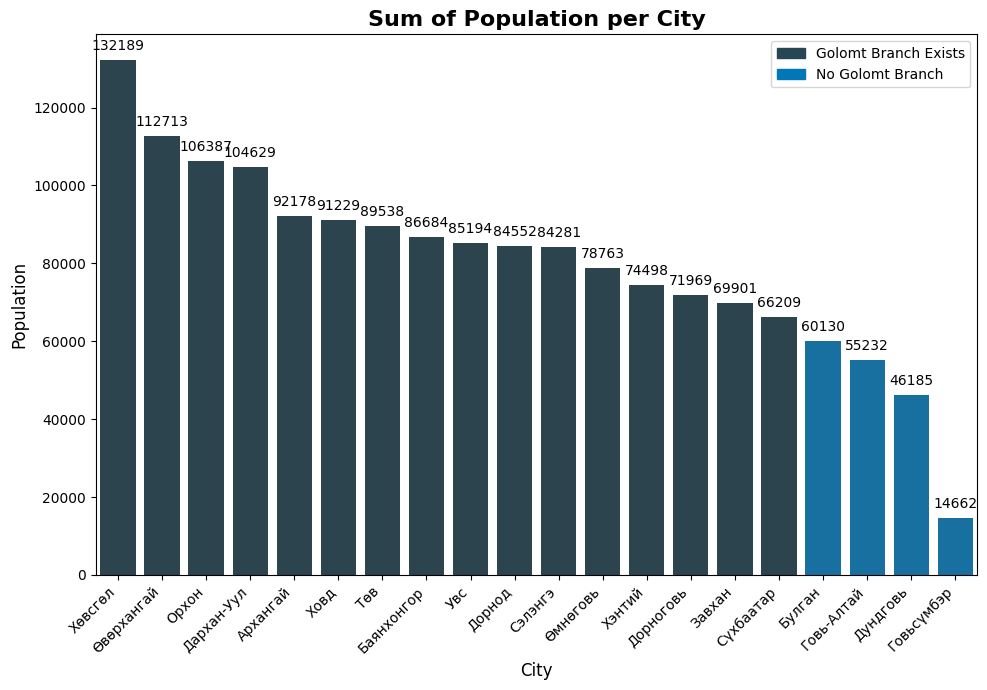

/tmp/ipython-input-19-3396388499.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df,x='City',y=feature,palette=[color_map[city] for city in df['City']])
/tmp/ipython-input-19-3396388499.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


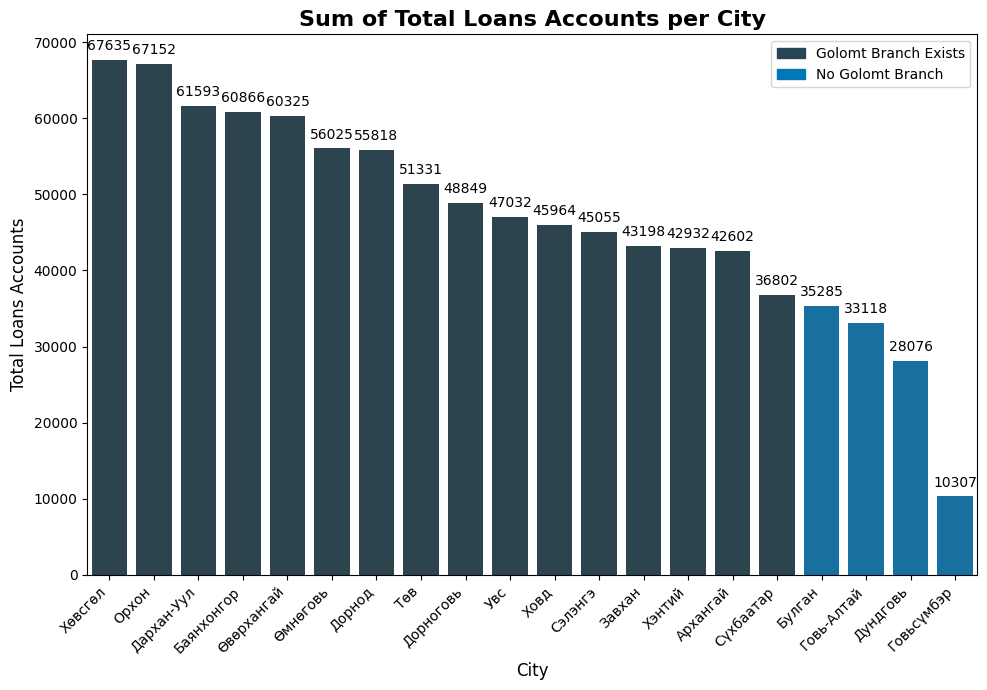

/tmp/ipython-input-19-3396388499.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df,x='City',y=feature,palette=[color_map[city] for city in df['City']])
/tmp/ipython-input-19-3396388499.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


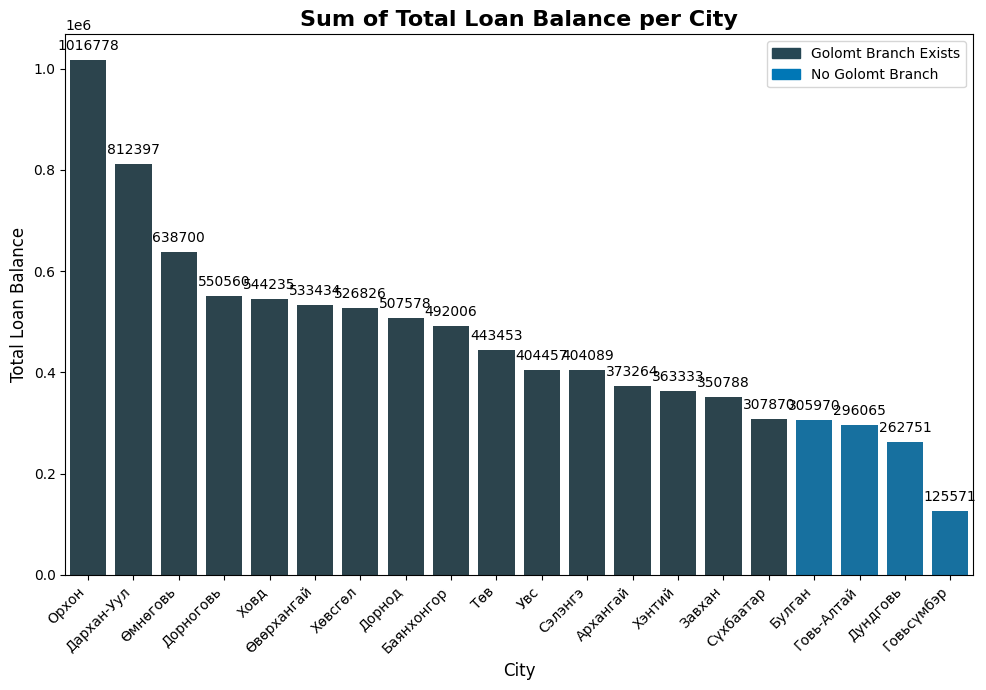

/tmp/ipython-input-19-3396388499.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df,x='City',y=feature,palette=[color_map[city] for city in df['City']])
/tmp/ipython-input-19-3396388499.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


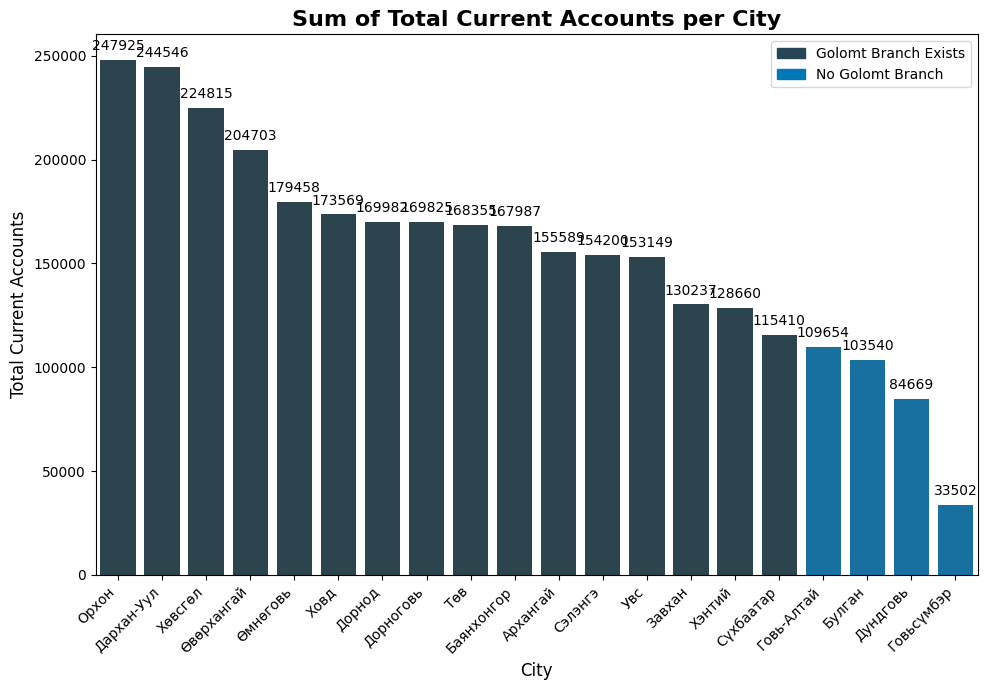

/tmp/ipython-input-19-3396388499.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df,x='City',y=feature,palette=[color_map[city] for city in df['City']])
/tmp/ipython-input-19-3396388499.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


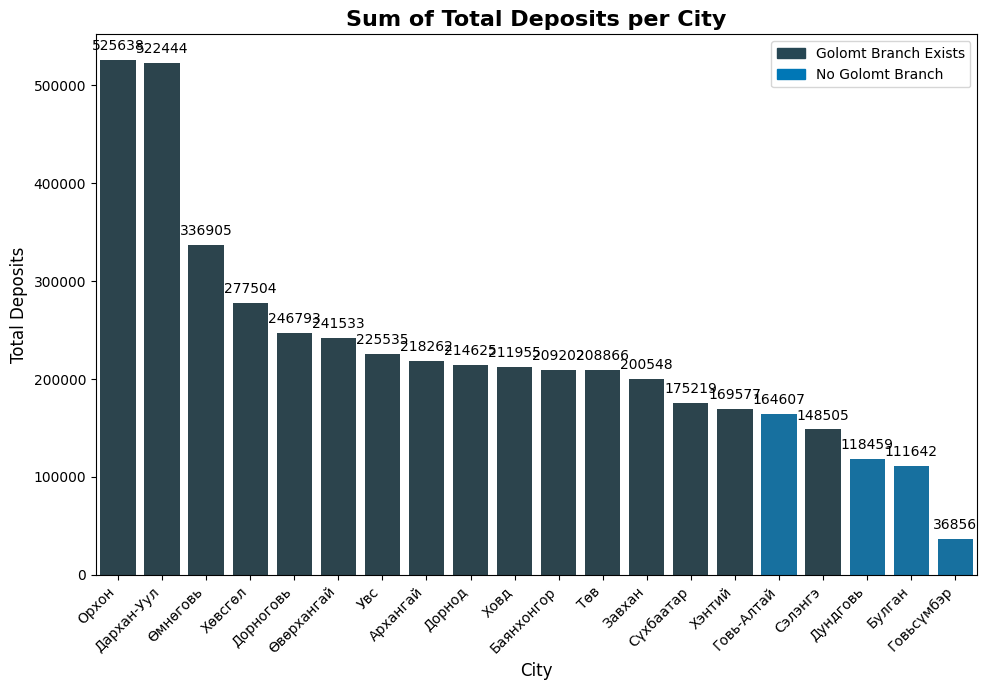

/tmp/ipython-input-19-3396388499.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df,x='City',y=feature,palette=[color_map[city] for city in df['City']])
/tmp/ipython-input-19-3396388499.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


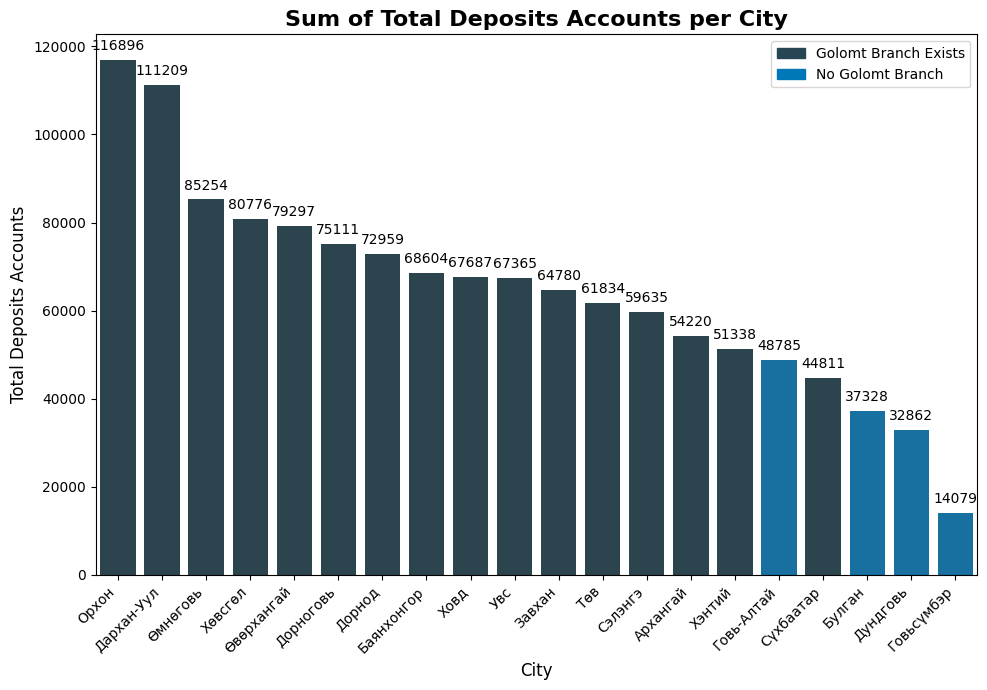

/tmp/ipython-input-19-3396388499.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df,x='City',y=feature,palette=[color_map[city] for city in df['City']])
/tmp/ipython-input-19-3396388499.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


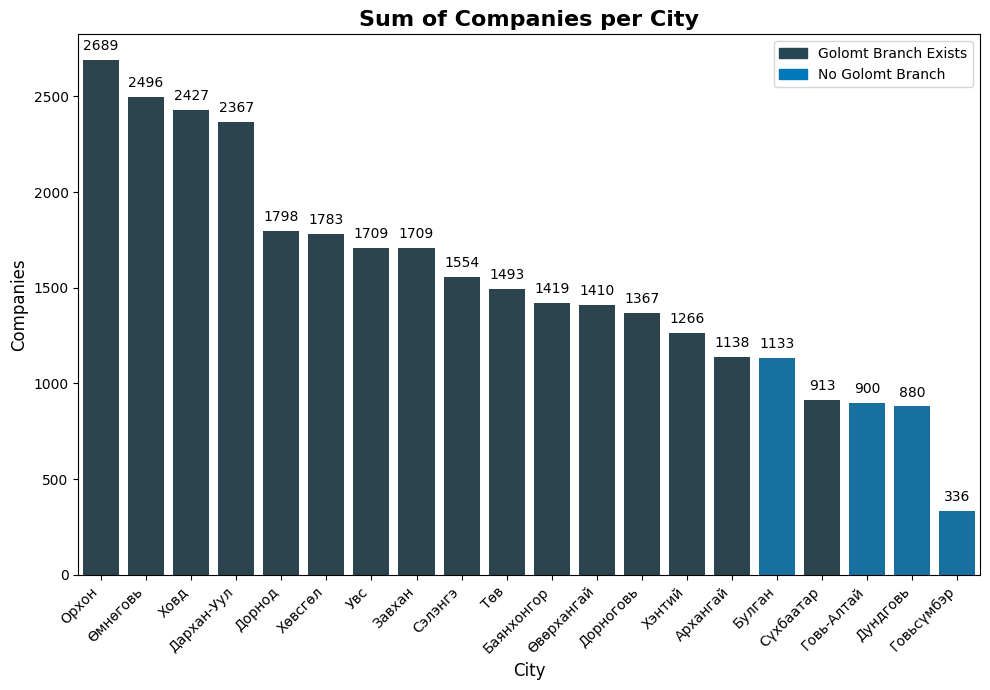

/tmp/ipython-input-19-3396388499.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df,x='City',y=feature,palette=[color_map[city] for city in df['City']])
/tmp/ipython-input-19-3396388499.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


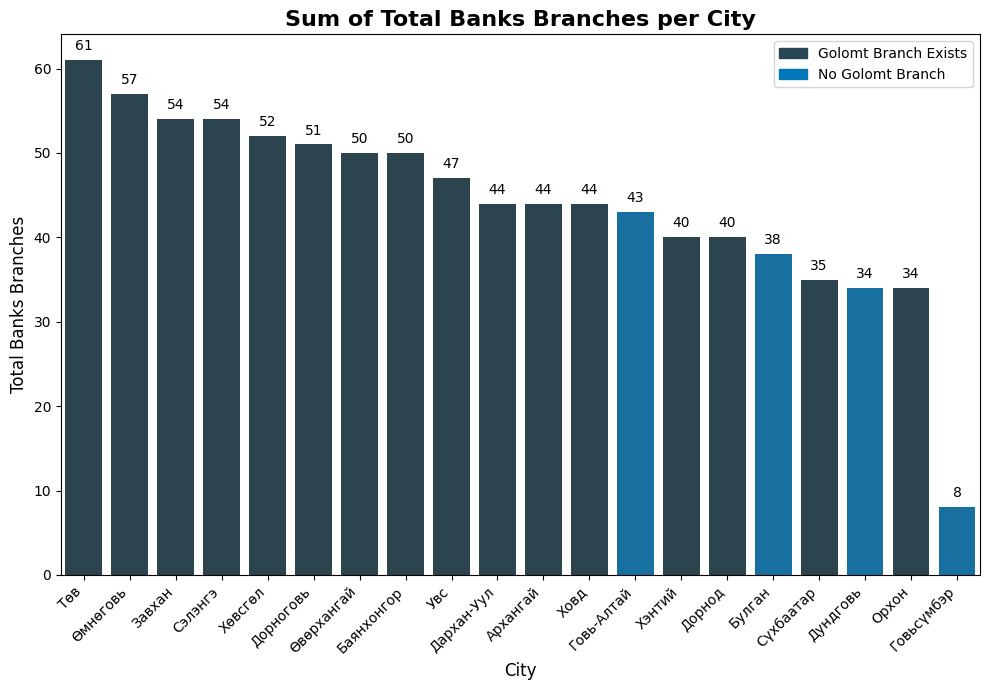

/tmp/ipython-input-19-3396388499.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df,x='City',y=feature,palette=[color_map[city] for city in df['City']])
/tmp/ipython-input-19-3396388499.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


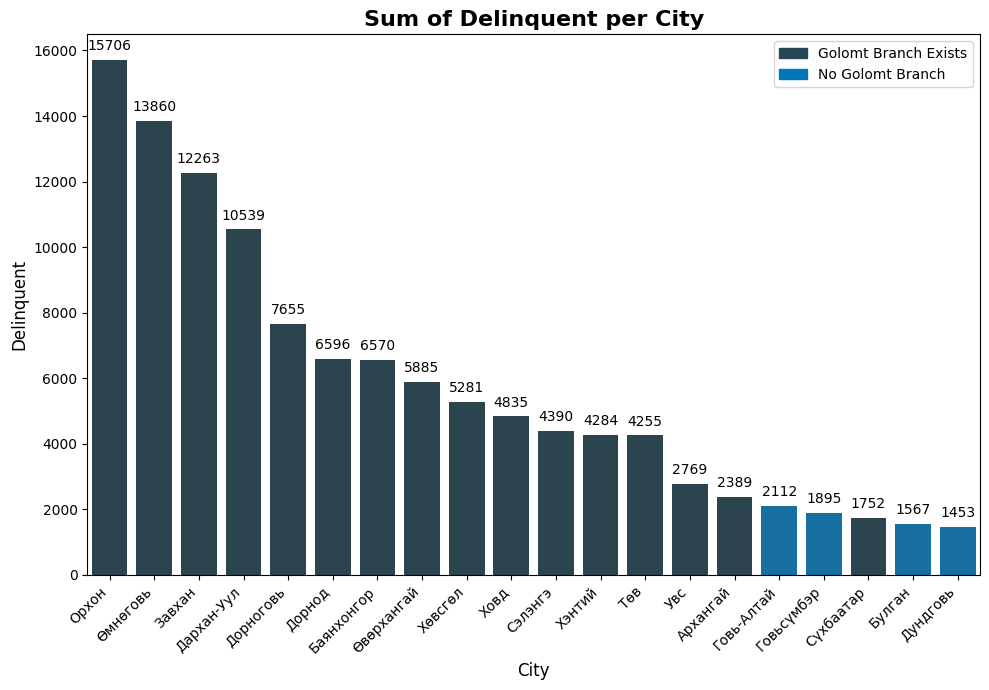

/tmp/ipython-input-19-3396388499.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df,x='City',y=feature,palette=[color_map[city] for city in df['City']])
/tmp/ipython-input-19-3396388499.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


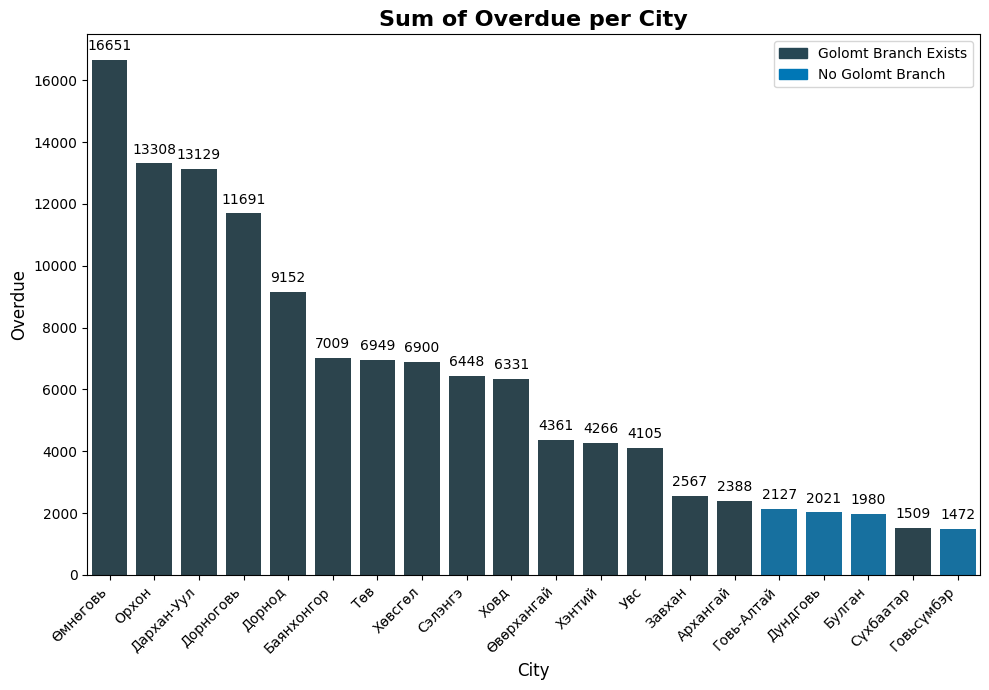

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# Prepare data
top_districts = final_ranking[['City', 'District']].copy()
top_merged = pd.merge(top_districts, merged_df, on=['City', 'District'], how='left')

top_merged['City'] = top_merged['City'].str.title()
top_merged['District'] = top_merged['District'].str.title()
top_merged['label'] = top_merged['City'] + ' - ' + top_merged['District']
top_merged['has_golomt'] = top_merged['Golomt_branches'] > 0

# Prepare City Sum
selected_cities = top_merged['City'].str.title().unique()

city_aggregated = merged_df[merged_df['City'].str.title().isin(selected_cities)].copy()
city_aggregated['City'] = city_aggregated['City'].str.title()

raw_features = [
    'Population',           # Total population
    'Total_loans_accounts',
    'Total_loan_balance',
    'Total_current_accounts',
    'Total_deposits',
    'Total_deposits_accounts',
    'Companies',
    'Total_banks_branches',
    'Delinquent',
    'Overdue'
]

city_grouped = city_aggregated.groupby('City')[raw_features].sum().reset_index()

# Cities with Golomt Branch
cities_with_golomt = merged_df[merged_df['Golomt_branches'] > 0]['City'].str.title().unique()
city_grouped['has_golomt'] = city_grouped['City'].isin(cities_with_golomt)

color_existing = "#264653"  # Teal (Golomt branch exists)
color_target = "#0077b6"  # Coral (No Golomt branch)

city_color_map = {
    city: (color_existing if has_golomt else color_target)
    for city, has_golomt in zip(city_grouped['City'], city_grouped['has_golomt'])
}


def plot_feature_by_city(df, feature, title, color_map):
    df = df.sort_values(feature, ascending=False)

    plt.figure(figsize=(10, 7))
    ax = sns.barplot(data=df,x='City',y=feature,palette=[color_map[city] for city in df['City']])

    plt.title(title, fontsize=16, weight='bold')
    plt.xlabel('City', fontsize=12)
    plt.ylabel(feature.replace('_', ' ').title(), fontsize=12)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    for container in ax.containers:
        ax.bar_label(container, fmt='%.0f', fontsize=10, label_type='edge', padding=5)

    legend_handles = [Patch(color=color_existing, label='Golomt Branch Exists'),Patch(color=color_target, label='No Golomt Branch')]
    plt.legend(handles=legend_handles, loc='upper right')

    plt.tight_layout()
    plt.show()

# Plot All Features
for feature in raw_features:
    plot_feature_by_city(city_grouped, feature,f'Sum of {feature.replace("_", " ").title()} per City',city_color_map)